In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import rankdata,spearmanr,pearsonr
import urllib2
import json

In [2]:


def getData(factorName,token):
    conf = {
    "TOKEN_URL":"http://auth.yunkuanke.com/oauth/token",
	"TOKEN_BODY":"client_id=ContentClient&client_secret=1249389CD9CA4429939689C9DDE19CFE&grant_type=password&scope=read&username=admin&password=admin",
	"TOKEN_HEADERS":{"Content-Type":"application/x-www-form-urlencoded;charset=UTF-8"},
	"DATA_URL":"http://factorapi.yunkuanke.com/factor/downloadFileByFacCode.do?factorCode="
    }

    req = urllib2.Request(url=conf["TOKEN_URL"], data=conf["TOKEN_BODY"], headers=conf["TOKEN_HEADERS"])
    res = urllib2.urlopen(req).read()
    token = json.loads(json.loads(res)['data'])["access_token"]
    req = urllib2.Request(url=conf["DATA_URL"] + factorName + "&access_token=" + token)
    return pd.read_csv(urllib2.urlopen(req),parse_dates=True,index_col=0)

In [3]:
close = getData('LZ_SP_FUTURE_QUOTE_CLOSE',token)
volume = getData('LZ_SP_FUTURE_QUOTE_VOLUME',token)
close_tb = getData('LZ_SP_FUTURE_QUOTE_CLOSE_TB',token)
volume_tb = getData('LZ_SP_FUTURE_QUOTE_VOLUME_TB',token)
iclose_tb  = getData('LZ_SI_FUTURE_QUOTE_CLOSE_TB',token)
ivolume_tb = getData('LZ_SI_FUTURE_QUOTE_CLOSE_TB',token)

Getting LZ_SP_FUTURE_QUOTE_CLOSE Data...
Getting LZ_SP_FUTURE_QUOTE_VOLUME Data...
Getting LZ_SP_FUTURE_QUOTE_CLOSE_TB Data...
Getting LZ_SP_FUTURE_QUOTE_VOLUME_TB Data...
Getting LZ_SI_FUTURE_QUOTE_CLOSE_TB Data...
Getting LZ_SI_FUTURE_QUOTE_CLOSE_TB Data...


In [42]:
len(volume_tb.columns)

4247

In [41]:
#close_tb=close_tb.join(iclose_tb)
volume_tb=volume_tb.join(ivolume_tb)

In [37]:
close_tb.head()

,a0501,a0503,a0505,a0507,a0509,a0511,a0601,a0603,a0605,a0607,...,TF1606,TF1609,TF1612,TF1703,TF1706,TF1709,TF1712,IC1707,IF1707,IH1707
LZ_SP_FUTURE_QUOTE_CLOSE_TB-d,,,,,,,,,,,,,,,,,,,,,
2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,2885.0,2656.0,2577.0,2572.0,2604.0,2515.0,2517.0,NaN,2545.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,2889.0,2665.0,2586.0,2583.0,2613.0,2518.0,2520.0,2559.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,2893.0,2671.0,2614.0,2604.0,2632.0,2545.0,2550.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,2885.0,2665.0,2610.0,2599.0,2633.0,2536.0,2544.0,NaN,2564.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
pct_tb=(close_tb-close_tb.shift(1))/close_tb.shift(1)
pct=(close-close.shift(1))/close.shift(1)
volume.fillna(0,inplace=True)
volume_tb.fillna(0,inplace=True)

In [44]:
l=[]
for i in close.columns.values:
    l.append(filter(str.isalpha,i.split('.')[0][:4]))
new_col=set(l)#万德数据
l2=[]
for i in close_tb.columns.values:
    l2.append(filter(str.isalpha,i).upper())
new_col_tb=set(l2)#淘宝数据

In [46]:
new_col-new_col_tb

{'AF', 'EF', 'IFM', 'IM', 'TM', 'TT'}

In [47]:
#淘宝数据连续合约计算
print '淘宝数据连续合约计算中...'
con_tb=pd.DataFrame(index=close_tb.index,columns=new_col_tb)
np_vol_tb=np.array(volume_tb)
avg_vol_tb=volume_tb.copy()
for i in range(5,np_vol_tb.shape[0]):
    avg_vol_tb.iloc[i]=np.nanmean(np_vol_tb[i-5:i],axis=0)
avg_vol_tb.fillna(0,inplace=True)
for k in new_col_tb:
    kind=[]
    for i in avg_vol_tb.columns:
        if filter(str.isalpha,i).upper()==k:
            kind.append(i)
    location=avg_vol_tb[kind].idxmax(axis=1)
    z=zip(location.index,location.values)
    for i in z:
        con_tb.ix[i[0],k]=pct_tb.ix[i]

淘宝数据连续合约计算中...


In [48]:
#淘宝数据连续合约计算
print '淘宝数据连续合约计算中...'
con_tb=pd.DataFrame(index=close_tb.index,columns=new_col_tb)
np_vol_tb=np.array(volume_tb)
avg_vol_tb=volume_tb.copy()
for i in range(5,np_vol_tb.shape[0]):
    avg_vol_tb.iloc[i]=np.nanmean(np_vol_tb[i-5:i],axis=0)
avg_vol_tb.fillna(0,inplace=True)
for k in new_col_tb:
    kind=[]
    for i in avg_vol_tb.columns:
        if filter(str.isalpha,i).upper()==k:
            kind.append(i)
    location=avg_vol_tb[kind].idxmax(axis=1)
    z=zip(location.index,location.values)
    for i in z:
        con_tb.ix[i[0],k]=pct_tb.ix[i]

淘宝数据连续合约计算中...


In [49]:
#万德数据连续合约计算
print '万德数据连续合约计算连续合约计算中...'
con=pd.DataFrame(index=close.index,columns=new_col)
np_vol=np.array(volume)
avg_vol=volume.copy()
for i in range(5,np_vol.shape[0]):
    avg_vol.iloc[i]=np.nanmean(np_vol[i-5:i],axis=0)
for k in new_col:
    kind=[]
    for i in avg_vol.columns:
        if filter(str.isalpha,i.split('.')[0][:4])==k:
            kind.append(i)
    location=avg_vol[kind].idxmax(axis=1)
    z=zip(location.index,location.values)
    for i in z:
        con.ix[i[0],k]=pct.ix[i]

万德数据连续合约计算连续合约计算中...


In [50]:
#以万德为基础，用淘宝数据填补nan
con_comb=con.combine_first(con_tb)
con_comb.fillna(method='ffill',inplace=True)

In [51]:
#读期货持仓
print '读期货持仓...'
table = pd.read_excel(u'D:\Var\SR2542宽鼎多策略对冲11号私募证券投资基金委托资产资产估值表20170531.xls',skiprows=[0,1,2,3,4,6,7])
table.fillna(0,inplace=True)

trade=pd.Series()
amount=pd.Series()
loc=[]
for i,k in zip(table[u'科目名称'].index,table[u'科目名称'].values):
    if u'_成本' in '%s'%k and u'方' in '%s'%k or u'_冲抵成本' in '%s'%k:
        loc.append(i)
for i in range(0,len(loc),2):
    amount = amount.append(table.ix[loc[i]+1:loc[i+1]-1,u'成本'])
    trade = trade.append(table.ix[loc[i]+1:loc[i+1]-1,u'科目名称'])
data=pd.DataFrame()
data['stocks']=trade
data['amount']=amount

w=data['amount']/np.sum(abs(data['amount']))
money=np.sum(abs(data['amount']))

读期货持仓...


In [52]:
#持仓收益率合并
print '持仓收益率合并...'
f=[]
for i in data.stocks:
    f.append(filter(str.isalpha,str(i)))
p=con_comb[f]['2016-01-01':'2018-05-23']
r=np.array(np.matrix(w)*np.matrix(p).T)[0]

持仓收益率合并...


In [53]:
#计算标准差
print '计算标准差...'
theta=[0]*(len(r)+1)
alpha=0.94
theta[0]=r[0]
for i in range(1,len(r)+1):
    theta[i]=np.sqrt(0.94*theta[i-1]**2+0.06*r[i-1]**2)

计算标准差...


In [54]:
#计算在险价值
print '在险价值为',money*1.65*theta[i]

在险价值为 68133.5996045


In [55]:
test_r=r[20:]
test_theta=theta[21:]
print '历史收益率超出估计比例：',len(test_r[test_r-1.65*np.array(test_theta)>0])/float(len(test_r))
print '历史收益率低于估计比例：',len(test_r[test_r+1.65*np.array(test_theta)<0])/float(len(test_r))
print '总计                  ：',len(test_r[test_r-1.65*np.array(test_theta)>0])/float(len(test_r))+len(test_r[test_r+1.65*np.array(test_theta)<0])/float(len(test_r))

历史收益率超出估计比例： 0.0615384615385
历史收益率低于估计比例： 0.0369230769231
总计                  ： 0.0984615384615


0.0615384615385
0.0369230769231
0.0984615384615


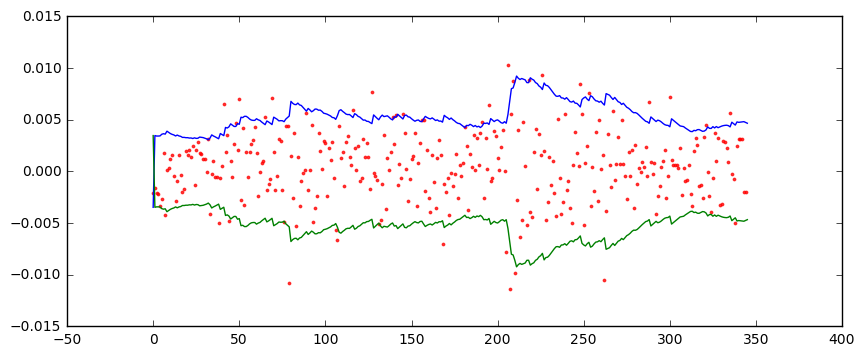

In [56]:
#历史检验
plt.figure(figsize=(10,4))
plt.plot(1.65*np.array(theta))
plt.plot(-1.65*np.array(theta))
plt.scatter(range(len(r)),r,s=3,alpha=0.75,color='r',edgecolor='r')
test_r=r[20:]
test_theta=theta[21:]
print len(test_r[test_r-1.65*np.array(test_theta)>0])/float(len(test_r))
print len(test_r[test_r+1.65*np.array(test_theta)<0])/float(len(test_r))
print len(test_r[test_r-1.65*np.array(test_theta)>0])/float(len(test_r))+len(test_r[test_r+1.65*np.array(test_theta)<0])/float(len(test_r))

In [517]:
13000000*np.std(r)

34690.731194715358

In [519]:
3100000*3.5/365/100*200

59452.054794520554